In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import mplfinance as mpf
import datetime
import matplotlib.dates as mdates

df = pd.read_csv("stock_price.csv", encoding ="utf-8")

df= df.rename(columns={"日付け": "Date", "終値": "Close", "始値": "Open", "高値": "High", "安値": "Low", "出来高": "Volume", "変化率 %": "Change"}) #mplfinanceに使えるようにコラム名を変更
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
#df["index"] = range(len(df))
#df.insert(0, "index", df.pop("index"))

df = df.sort_index(ascending=True)
df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1.28B,16.25%
1987-02-13,172.5,176.5,176.5,172.5,422.38M,-5.43%
1987-02-16,175.5,166.7,175.5,165.7,360.51M,1.74%
1987-02-17,182.4,176.5,184.3,175.5,881.51M,3.93%
1987-02-18,191.2,186.3,191.2,186.3,795.09M,4.82%
...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%
2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9202 entries, 1987-02-12 to 2024-08-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   9202 non-null   float64
 1   Open    9202 non-null   float64
 2   High    9202 non-null   float64
 3   Low     9202 non-null   float64
 4   Volume  9202 non-null   object 
 5   Change  9202 non-null   object 
dtypes: float64(4), object(2)
memory usage: 503.2+ KB


In [55]:
# Volumeをプロットするために、floatへ変換
def convert_volume(value):
    value = str(value)
    if value[-1] == "M":
        return float(value[:-1]) * 1000000
    elif value[-1] == "B":
        return float(value[:-1]) * 1000000000
    return float(value)

# "Volume" 列を更新
df["Volume"] = df["Volume"].apply(convert_volume)

# データの前処理と特徴量エンジニアリング

現代ポートフォリオ理論に関する数多くの研究および私個人の経験では、株価のランダムウォーク的な性質により投資家心理に基づいて短期な株価予想が可かもしれないが長期的に市場平均からの影響も株価が必ずしも過去の株価によって影響されると言えないため過去のデータでに基づく予測が難しいと考えられる。

従って、今回は市場平均とデータもなるべく多くのテクニカル分析でよく使われるパラメータを導入しすることから始める。

参考:

[1] https://myfrankblog.com/technical_analysis_with_python/#i

[2] https://qiita.com/tnozoo/items/60151108f946c48b666d

[3] https://qiita.com/tnozoo/items/ac390974e9c6586ec4ec

[4] https://qiita.com/tnozoo/items/81a972fe911a28a781f9

[5] A. Kendall et al., 2018 Proc. IEEE Conf. Comput. Vis. Pattern Recognit. 7482 7491.


In [56]:
# technical分析に用いられるパラメータの追加(pipeline)[1][2]
# 1.移動平均(5と25日間)
def rolling(df):
    
    df = df.copy()

    df.loc[:, "SMA5"] = df["Close"].rolling(window=5).mean()
    df.loc[:, "SMA10"] = df["Close"].rolling(window=15).mean()
    df.loc[:, "SMA25"] = df["Close"].rolling(window=25).mean()
    
    return df

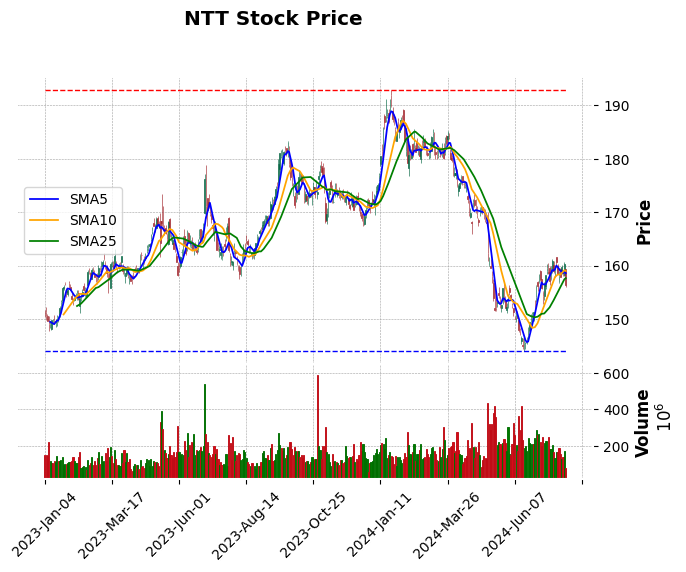

In [57]:
# 移動平均のプロット
# ここでは最近2023年1/月からのデータだけプロットして観察する
# 2023年6月は株式分割が行われた
date_filter = "2022-12-31"
date_filtered_df = df[df.index > date_filter]

df_sma = rolling(date_filtered_df)

apds = [
    mpf.make_addplot(df_sma["SMA5"], color="blue", label="SMA5"),
    mpf.make_addplot(df_sma["SMA10"], color="orange", label="SMA10"),
    mpf.make_addplot(df_sma["SMA25"], color="green", label="SMA25")
]

max_price = df_sma['High'].max()
min_price = df_sma['Low'].min()

# 最大値線と最小値線
max_line = mpf.make_addplot([max_price] * len(df_sma), color='r', linestyle='--', width=1)
min_line = mpf.make_addplot([min_price] * len(df_sma), color='b', linestyle='--', width=1)

# ローソク足チャート+移動平均
mpf.plot(
    data = df_sma,
    volume = True,
    type = "candle",
    addplot=[*apds, max_line, min_line],
    style = "charles",
    title = "NTT Stock Price",
    ylabel = "Price",
    ylabel_lower = "Volume",
)

In [58]:
# 2.ボリンジャーバンド[3]
# ±1σ ＝ n日の移動平均 ± n日の標準偏差
# ±2σ ＝ n日の移動平均 ± n日の標準偏差 × 2
# ±3σ ＝ n日の移動平均 ± n日の標準偏差 × 3

def bollingerband(c, period):
    
    bbma = c.rolling(window=period).mean() ## 平均
    bbstd = c.rolling(window=period).std() ## 標準偏差
    
    bbh1 = bbma + bbstd * 1
    bbl1 = bbma - bbstd * 1
    bbh2 = bbma + bbstd * 2
    bbl2 = bbma - bbstd * 2
    bbh3 = bbma + bbstd * 3
    bbl3 = bbma - bbstd * 3
    
    return bbh1, bbl1, bbh2, bbl2, bbh3, bbl3

def macd(c, n1, n2, ns):
    
    ema_short = c.ewm(span=n1,adjust=False).mean()
    ema_long = c.ewm(span=n2,adjust=False).mean()
    macd = ema_short - ema_long
    signal = macd.ewm(span=ns,adjust=False).mean()
    histogram = macd - signal
    histogramplus = histogram.where(histogram > 0, 0)
    histogramminus = histogram.where(histogram < 0, 0)
    
    return macd, signal, histogram, histogramplus, histogramminus

def rsi(c, period):
    
    diff = c.diff() #前日比
    up = diff.copy() #上昇
    down = diff.copy() #下落
    up = up.where(up > 0, np.nan)
    down = down.where(down < 0, np.nan)
    upma = up.ewm(span=period,adjust=False).mean() #平均
    downma = down.abs().ewm(span=period,adjust=False).mean() #絶対値の平均
    rs = upma / downma
    rsi = 100 - (100 / (1.0 + rs))
    
    return rsi

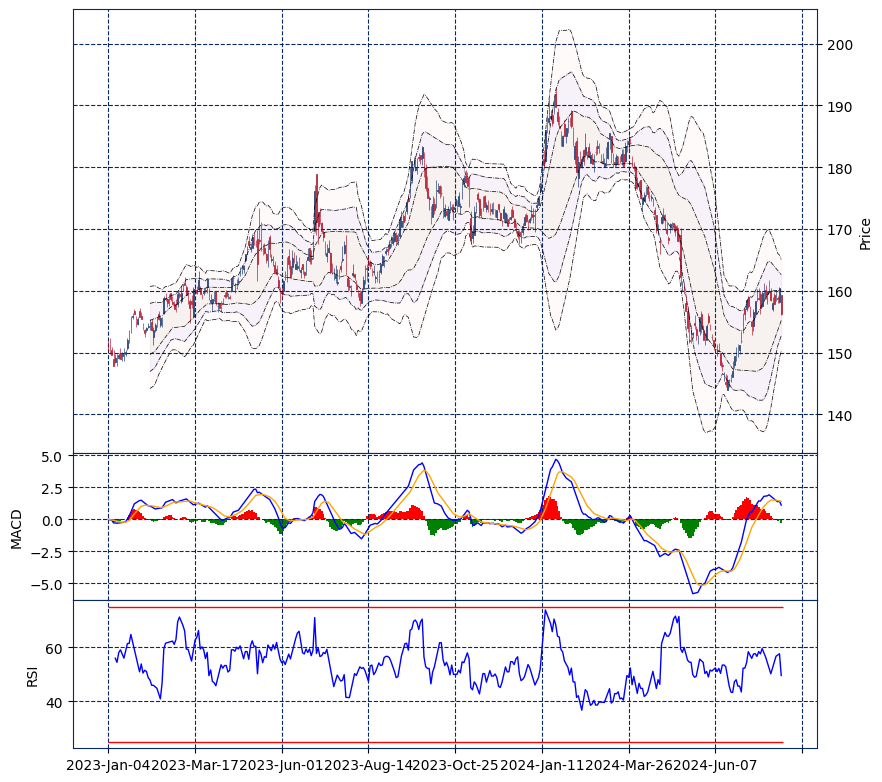

In [59]:
# float 型に
o = df_sma["Open"]
c = df_sma["Close"]
l = df_sma["Low"]
h = df_sma["High"]

# ボリンジャーバンド（移動平均=25日線)
bbh1,bbl1,bbh2,bbl2,bbh3,bbl3 = bollingerband(c, 25)

# MACD（短期=12，長期=26，シグナル=9）
macd_,macdsignal,histogram,histogramplus,histogramminus = macd(c,12,26,9)

# RSI（14日）
rsi_ = rsi(c, 14)

# 高さの比を 3:1:1 で GridSpec を用意する
fig = mpf.figure(figsize=(9.6, 9.6), style="starsandstripes")
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0, height_ratios=(3,1,1))
(ax1,ax2,ax3) = gs.subplots(sharex="col")

# ボリンジャーバンドは axes No.1 に描く
bbargs = dict(ax=ax1, width=.5, linestyle="dashdot", color="black")

# MACD は axes No.2 に描く
macdargs = dict(ax=ax2, width=1, ylabel="MACD")

# RSI は axes No.3 に描く
rsiargs = dict(ax=ax3, width=1, ylabel="RSI")

# プロットを作成する(ボリンジャーバンド，MACD，RSI)
ap = [
    mpf.make_addplot(bbh1, **bbargs),
    mpf.make_addplot(bbl1, **bbargs),
    mpf.make_addplot(bbh2, **bbargs),
    mpf.make_addplot(bbl2, **bbargs),
    mpf.make_addplot(bbh3, **bbargs),
    mpf.make_addplot(bbl3, **bbargs),
    mpf.make_addplot(macd_, **macdargs, color="blue"),
    mpf.make_addplot(macdsignal, **macdargs, color="orange"),
    mpf.make_addplot(histogramplus, **macdargs, color="red", type="bar"),
    mpf.make_addplot(histogramminus, **macdargs, color="green", type="bar"),
    mpf.make_addplot(rsi_, **rsiargs, color="blue")
]

# ボリンジャーバンド(axes=1)の間を塗りつぶす（色は適当）
ax1.fill_between(x=range(0, len(df_sma.index)), y1=bbh3.values, y2=bbl3.values, alpha=0.02, color="red")
ax1.fill_between(x=range(0, len(df_sma.index)), y1=bbh2.values, y2=bbl2.values, alpha=0.03, color="blue")
ax1.fill_between(x=range(0, len(df_sma.index)), y1=bbh1.values, y2=bbl1.values, alpha=0.04, color="yellow")

# RSI(axes=3) の25%と75%に線を引く
ax3.hlines(xmin=0, xmax=len(df_sma.index), y=25, linewidth=1, color="red")
ax3.hlines(xmin=0, xmax=len(df_sma.index), y=75, linewidth=1, color="red")

# ローソク足を描く，用意したプロットを渡す
mpf.plot(df_sma, ax=ax1, addplot=ap, style="starsandstripes", type="candle", xrotation=30, ylabel="Price")
mpf.show()

In [60]:
# 3.一目均衡表チャート
def ichimoku(o, h, l, c):
    ## 当日を含めた過去26日間の最高値
    ## 当日を含めた過去 9日間の最高値
    ## 当日を含めた過去52日間の最高値
    max26 = h.rolling(window=26).max()
    max9  = h.rolling(window=9).max()
    max52 = h.rolling(window=52).max()
    ## 当日を含めた過去26日間の最安値
    ## 当日を含めた過去 9日間の最安値
    ## 当日を含めた過去52日間の最安値
    min26 = l.rolling(window=26).min()
    min9  = l.rolling(window=9).min()
    min52 = l.rolling(window=52).min()

    ## 基準線=（当日を含めた過去26日間の最高値+最安値）÷2
    ## 転換線=（当日を含めた過去9日間の最高値+最安値）÷2
    kijun = (max26 + min26) / 2
    tenkan = (max9 + min9) / 2
    ## 先行スパン1=｛（転換値+基準値）÷2｝を26日先行させて表示
    senkospan1 = (kijun + tenkan) / 2
    senkospan1 = senkospan1.shift(26)
    ## 先行スパン2=｛（当日を含めた過去52日間の最高値+最安値）÷2｝を26日先行させて表示
    senkospan2 = (max52 + min52) / 2
    senkospan2 = senkospan2.shift(26)
    ## 遅行スパン= 当日の終値を26日遅行させて表示
    chikouspan = c.shift(-26)

    return kijun, tenkan, senkospan1, senkospan2, chikouspan

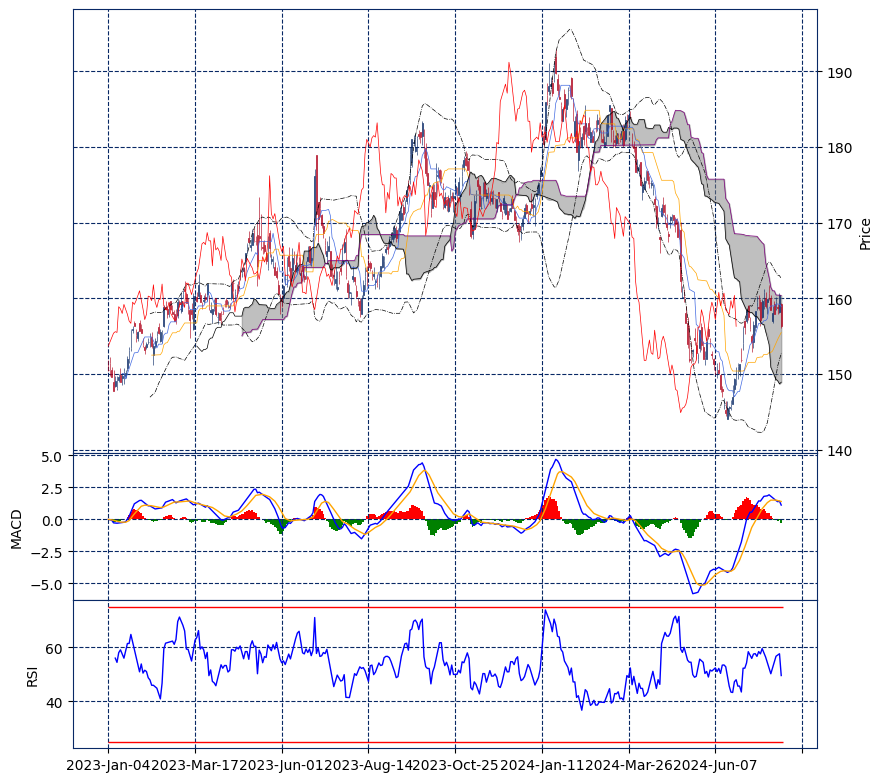

In [61]:
# ボリンジャーバンド（移動平均25日線）
bbh1, bbl1, bbh2, bbl2, bbh3, bbl3 = bollingerband(c, 25)
# MACD（短期=12，長期=26，シグナル=9）
macd_, macdsignal, histogram, histogramplus, histogramminus = macd(c, 12, 26, 9)
# RSI（14日）
rsi_ = rsi(c, 14)
# 一目均衡表
kijun, tenkan, senkospan1, senkospan2, chikouspan = ichimoku(o, h, l, c)
    
# 高さの比を 3:1:1 で GridSpec を用意する
fig = mpf.figure(figsize=(9.6, 9.6), style='starsandstripes')
gs = fig.add_gridspec(3, 1, hspace=0, wspace=0, height_ratios=(3, 1, 1))
(ax1,ax2,ax3) = gs.subplots(sharex='col')

# ボリンジャーバンドは axes No.1 に描く
bbargs = dict(ax=ax1, width=.5, linestyle='dashdot', color='black')
# MACD は axes No.2 に描く
macdargs = dict(ax=ax2, width=1, ylabel='MACD')
# RSI は axes No.3 に描く
rsiargs = dict(ax=ax3, width=1, ylabel='RSI')
# 一目均衡表 axes No.1 に描く
ichimokuargs = dict(ax=ax1, width=.5)

# プロットを作成する(ボリンジャーバンド，MACD，RSI，一目均衡表)
ap = [
    mpf.make_addplot(bbh2, **bbargs),
    mpf.make_addplot(bbl2, **bbargs),
    mpf.make_addplot(macd_, **macdargs, color='blue'),
    mpf.make_addplot(macdsignal, **macdargs, color='orange'),
    mpf.make_addplot(histogramplus, **macdargs, color='red', type='bar'),
    mpf.make_addplot(histogramminus, **macdargs, color='green', type='bar'),
    mpf.make_addplot(rsi_, **rsiargs, color='blue'),
    mpf.make_addplot(kijun, **ichimokuargs, color='orange'),
    mpf.make_addplot(tenkan, **ichimokuargs, color='royalblue'),
    mpf.make_addplot(senkospan1, **ichimokuargs, color='black'),
    mpf.make_addplot(senkospan2, **ichimokuargs, color='purple'),
    mpf.make_addplot(chikouspan, **ichimokuargs, color='red')
]

# RSI(axes=3) の25%と75%に線を引く
ax3.hlines(xmin=0, xmax=len(df_sma.index), y=25, linewidth=1, color='red')
ax3.hlines(xmin=0, xmax=len(df_sma.index), y=75, linewidth=1, color='red')

# 一目均衡表(axes=1)の先行スパン１と先行スパン２の間を塗りつぶす
ax1.fill_between(x=range(0, len(df_sma.index)), y1=senkospan1.values, y2=senkospan2.values, alpha=0.5, color='gray')

# ローソク足を描く，用意したプロットを渡す
mpf.plot(df_sma, ax=ax1, addplot=ap, style='starsandstripes', type='candle', xrotation=30, ylabel='Price')
mpf.show()

In [62]:
df_sma

,Close,Open,High,Low,Volume,Change,SMA5,SMA10,SMA25
Date,,,,,,,,,
2023-01-04,150.5,150.5,151.8,150.4,149720000.0,0.00%,NaN,NaN,NaN
2023-01-05,150.5,151.4,152.3,149.8,150520000.0,0.00%,NaN,NaN,NaN
2023-01-06,149.6,150.5,150.9,149.6,143880000.0,-0.58%,NaN,NaN,NaN
2023-01-10,147.8,149.0,150.5,147.8,223880000.0,-1.20%,NaN,NaN,NaN
2023-01-11,149.1,148.4,149.7,148.3,116360000.0,0.84%,149.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-07-26,157.9,159.3,159.6,157.9,155080000.0,-0.13%,159.02,158.333333,156.208
2024-07-29,159.7,158.7,160.2,158.4,126280000.0,1.14%,158.98,158.586667,156.716
2024-07-30,158.7,158.8,159.2,158.0,138140000.0,-0.63%,158.58,158.880000,157.088


In [63]:
# 4.市場平均データ
# 現代ポートフォリオ理論おとび私の経験によると個別銘柄は市場平均から強く影響を受け、この影響の度合いは分散投資で取り除くことができない
# 投資のリスクとして捉えられている。従って、市場平均の株価データは個別銘柄の予測において非常に大事で、個別銘柄との相関をも学習させる必
# 要がある。

df_ave = pd.read_csv("nikkei-225-index-historical-chart-data.csv", encoding = "utf-8")
df_ave = df_ave.rename(columns={"value": "Value_ave", "date": "Date"}) #mplfinanceに使えるようにコラム名を変更
df_ave["Date"]
df_ave["Date"] = pd.to_datetime(df_ave["Date"])
df_ave.set_index("Date", inplace=True)
df_ave

,Value_ave
Date,
1949-05-16,176.21
1949-05-17,174.80
1949-05-18,172.53
1949-05-19,171.34
1949-05-20,169.20
...,...
2024-12-16,39457.49
2024-12-17,39364.68
2024-12-18,39081.71


In [64]:
def pipeline(df):
    
    o = df["Open"]
    c = df["Close"]
    l = df["Low"]
    h = df["High"]

    # ボリンジャーバンド（移動平均25日線）
    bbh1, bbl1, bbh2, bbl2, bbh3, bbl3 = bollingerband(c, 25)
    # MACD（短期=12，長期=26，シグナル=9）
    macd_, macdsignal, histogram, histogramplus, histogramminus = macd(c, 12, 26, 9)
    # RSI（14日）
    rsi_ = rsi(c, 14)
    # 一目均衡表
    kijun, tenkan, senkospan1, senkospan2, chikouspan = ichimoku(o, h, l, c)
    
    df = rolling(df)
    df["kijun"] = kijun
    df["tenkan"] = tenkan
    df["senkospan1"] = senkospan1
    df["senkospan2"] = senkospan2
    df["chikouspan"] = chikouspan
    df["bbh1"] = bbh1
    df["bbl1"] = bbl1
    df["bbh2"] = bbh2
    df["bbl2"] = bbl2
    df["bbl2"] = bbl2
    df["bbh3"] = bbh3
    df["bbl3"] = bbl3
    df["macd_"] = macd_
    df["macdsignal"] = macdsignal
    df["histogram"] = histogram
    df["histogramplus"] = histogramplus
    df["histogramminus"] = histogramminus
    
    # 出来高も１つのタスクとして予測できるが、テクニカルパラメータの計算に必要ないため今回は省略
    # 変動率も同じ
    columns_to_drop = ["Volume", "Change"]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    return df

In [65]:
df_sma = rolling(df)
df_technical = pipeline(df_sma)

In [66]:
# データ結合
df_merged = df_technical.join(df_ave["Value_ave"], how="right")
df_merged.insert(4, "Value_ave", df_merged.pop("Value_ave"))
df_merged = df_merged.dropna()
df_merged

,Close,Open,High,Low,Value_ave,SMA5,SMA10,SMA25,kijun,tenkan,...,bbl1,bbh2,bbl2,bbh3,bbl3,macd_,macdsignal,histogram,histogramplus,histogramminus
Date,,,,,,,,,,,,,,,,,,,,,
1987-06-04,280.4,279.4,282.4,277.5,25366.10,279.02,280.400000,286.792,292.15,280.90,...,277.318620,305.738760,267.845240,315.212141,258.371859,-1.710321,-0.687362,-1.022958,0.000000,-1.022958
1987-06-05,277.5,279.4,281.4,277.5,25271.30,278.64,279.686667,286.520,292.15,280.90,...,276.876004,305.807993,267.232007,315.451989,257.588011,-1.848068,-0.919503,-0.928565,0.000000,-0.928565
1987-06-08,277.5,278.4,279.4,277.5,25523.89,278.26,279.360000,286.128,292.65,280.90,...,276.319266,305.745468,266.510532,315.554203,256.701797,-1.934929,-1.122589,-0.812341,0.000000,-0.812341
1987-06-09,279.4,277.5,279.4,277.5,25379.88,278.46,279.160000,285.344,292.65,280.90,...,275.828045,304.375910,266.312090,313.891865,256.796135,-1.829365,-1.263944,-0.565422,0.000000,-0.565422
1987-06-10,279.4,278.4,281.4,277.5,25738.95,278.84,279.286667,284.560,292.65,280.90,...,275.415876,302.848248,266.271752,311.992371,257.127629,-1.725811,-1.356317,-0.369494,0.000000,-0.369494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-19,145.6,145.5,145.8,144.4,38570.76,146.06,149.946667,151.260,151.50,147.80,...,148.084180,157.611640,144.908360,160.787460,141.732540,-4.107988,-4.065407,-0.042582,0.000000,-0.042582
2024-06-20,146.0,145.7,146.6,145.3,38633.02,145.70,149.533333,150.940,150.80,147.80,...,147.650750,157.518500,144.361500,160.807751,141.072249,-4.002224,-4.052770,0.050546,0.050546,0.000000
2024-06-21,147.0,146.0,148.6,146.0,38596.47,145.80,149.046667,150.748,150.40,147.80,...,147.372090,157.499820,143.996180,160.875729,140.620271,-3.793979,-4.001012,0.207033,0.207033,0.000000


In [67]:
df_merged.info()
# 入力は24個
# 出力はClose, Open, High, Low, Value_aveの5個

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9093 entries, 1987-06-04 to 2024-06-25
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           9093 non-null   float64
 1   Open            9093 non-null   float64
 2   High            9093 non-null   float64
 3   Low             9093 non-null   float64
 4   Value_ave       9093 non-null   float64
 5   SMA5            9093 non-null   float64
 6   SMA10           9093 non-null   float64
 7   SMA25           9093 non-null   float64
 8   kijun           9093 non-null   float64
 9   tenkan          9093 non-null   float64
 10  senkospan1      9093 non-null   float64
 11  senkospan2      9093 non-null   float64
 12  chikouspan      9093 non-null   float64
 13  bbh1            9093 non-null   float64
 14  bbl1            9093 non-null   float64
 15  bbh2            9093 non-null   float64
 16  bbl2            9093 non-null   float64
 17  bbh3           

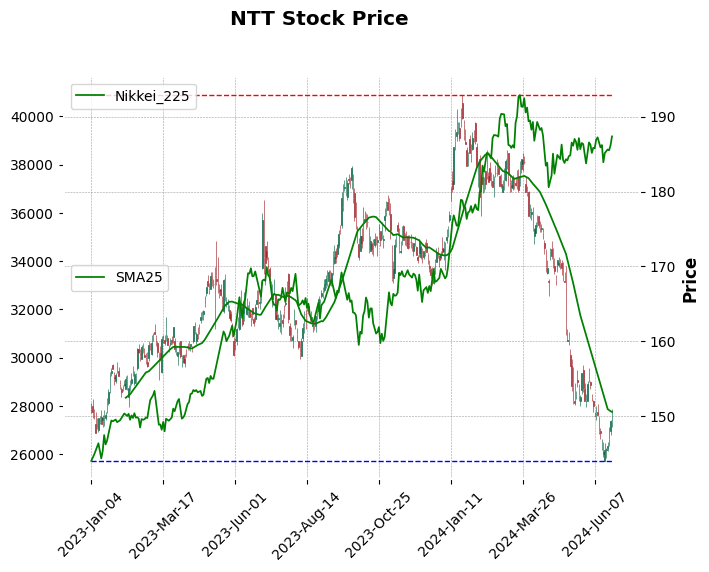

In [68]:
date_filter = "2022-12-31"
date_filtered_df = df_merged[df_merged.index > date_filter]

df_merged_filtered = rolling(date_filtered_df)

apds = [
    mpf.make_addplot(df_merged_filtered["SMA25"], color="green", label="SMA25"),
    mpf.make_addplot(df_merged_filtered["Value_ave"], color="green", label="Nikkei_225")
]

max_price = df_merged_filtered['High'].max()
min_price = df_merged_filtered['Low'].min()

# 最大値線と最小値線
max_line = mpf.make_addplot([max_price] * len(df_merged_filtered), color='r', linestyle='--', width=1)
min_line = mpf.make_addplot([min_price] * len(df_merged_filtered), color='b', linestyle='--', width=1)

# ローソク足チャート+移動平均
mpf.plot(
    data = df_merged_filtered,
    type = "candle",
    addplot=[*apds, max_line, min_line],
    style = "charles",
    title = "NTT Stock Price",
    ylabel = "Price",
)

# モデル選定

時系列データを用いた株価予測では、LSTMがよく使われている。モデルは無数発明されており、論文検索→githubから既に公開されているものを使用することができる。ここでは私が構想したマルチタスクモデルを簡単なアーキテクチャで実装したい。株価を予測するために、なるべく多くのパラメータを取り入れたい。従って、Close, High, Open, Low, Aveもそれぞれモデルで予測し、次の予測に使用する。予測値をもとに新しくSMA5、MACDなど算出する循環を取る。ここで舵を取ると想定するアーキテクチャはマルチタスクであり、参考文献[5]に記載されているように、複数の相関があるタスク(すなわちOpen, Highなど異なる予測値を持つタスク)を一つの共通のニューラルネットワークで学習することで、タスク間共通の部分が学習され、より本質を理解できるモデルを作ることができる。こうしたモデルはタスクを別々で学習したモデルより精度が高いことも確認されている。

In [69]:
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

In [70]:
df_merged.iloc[:-30]

,Close,Open,High,Low,Value_ave,SMA5,SMA10,SMA25,kijun,tenkan,...,bbl1,bbh2,bbl2,bbh3,bbl3,macd_,macdsignal,histogram,histogramplus,histogramminus
Date,,,,,,,,,,,,,,,,,,,,,
1987-06-04,280.4,279.4,282.4,277.5,25366.10,279.02,280.400000,286.792,292.15,280.90,...,277.318620,305.738760,267.845240,315.212141,258.371859,-1.710321,-0.687362,-1.022958,0.000000,-1.022958
1987-06-05,277.5,279.4,281.4,277.5,25271.30,278.64,279.686667,286.520,292.15,280.90,...,276.876004,305.807993,267.232007,315.451989,257.588011,-1.848068,-0.919503,-0.928565,0.000000,-0.928565
1987-06-08,277.5,278.4,279.4,277.5,25523.89,278.26,279.360000,286.128,292.65,280.90,...,276.319266,305.745468,266.510532,315.554203,256.701797,-1.934929,-1.122589,-0.812341,0.000000,-0.812341
1987-06-09,279.4,277.5,279.4,277.5,25379.88,278.46,279.160000,285.344,292.65,280.90,...,275.828045,304.375910,266.312090,313.891865,256.796135,-1.829365,-1.263944,-0.565422,0.000000,-0.565422
1987-06-10,279.4,278.4,281.4,277.5,25738.95,278.84,279.286667,284.560,292.65,280.90,...,275.415876,302.848248,266.271752,311.992371,257.127629,-1.725811,-1.356317,-0.369494,0.000000,-0.369494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-08,168.1,170.1,170.6,168.1,38202.37,169.92,170.413333,172.640,173.40,170.45,...,169.488810,178.942381,166.337619,182.093571,163.186429,-2.377135,-2.463200,0.086065,0.086065,0.000000
2024-05-09,167.9,168.1,169.2,167.9,38073.98,169.34,169.966667,172.288,173.05,169.95,...,169.117784,178.628431,165.947569,181.798647,162.777353,-2.405201,-2.451600,0.046399,0.046399,0.000000
2024-05-10,162.3,169.0,170.1,160.9,38229.11,167.70,169.293333,171.684,169.65,166.05,...,168.114957,178.822086,164.545914,182.391128,160.976872,-2.846504,-2.530581,-0.315923,0.000000,-0.315923


In [71]:
# train val を分ける
def create_dataset(data, look_back=60):
    
    X, y = [], []
    
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        y.append(data[i, :5]) 
        
    return np.array(X), np.array(y)

In [72]:
df_train = df_merged.iloc[:-30]
df_val = df_merged.iloc[-30:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(df_train.values)
scaled_val = scaler.transform(df_val.values)

look_back = 60
X_train, y_train = create_dataset(scaled_train, look_back)

In [73]:
def Network(n_input1, n_input2, n_output, n_neuron, n_layer, act_fn):
    
    inputs = keras.layers.Input(shape=(n_input1, n_input2))

    x = inputs

    skip_connections = []
    
    for i in range(n_layer):
        x = keras.layers.LSTM(units = n_neuron[i],
                              return_sequences=True)(x)  # 最後の層以外 return_sequences=True
        #skip connection
        if i > 0:
            x = keras.layers.Add()([x] + skip_connections)
            x = keras.layers.Activation(act_fn)(x)
            
        skip_connections.append(x)
        
    output = keras.layers.LSTM(n_output, return_sequences=False)(x)
    model = keras.models.Model(inputs=inputs, outputs=output)
    
    return model

In [74]:
class StockModel():

    def __init__(self, n_input1,n_input2, n_output, n_neuron, n_layer, epochs, loss_weights, act_fn):

        self.n_input1 = n_input1
        self.n_input2 = n_input2
        self.n_output = n_output
        self.n_neuron = n_neuron
        self.n_layer = n_layer
        self.epochs = epochs
        self.act_fn = act_fn
        self.loss_weights = loss_weights

    def build(self, optimizer, loss_fn):
        
        self._model = Network(self.n_input1, self.n_input2, self.n_output, self.n_neuron, self.n_layer, self.act_fn)
        self._optimizer = optimizer
        self._loss_fn = loss_fn
        
        return self

    def train_step(self, X, y, loop):

        with tf.GradientTape() as tape:
            tape.watch(self._model.trainable_variables)
            
            # 予測およびロス計算
            f_pred = self._model(X)
            
            loss1 = self.loss_weights[0] * self._loss_fn(f_pred[:, 0], y[:, 0])
            loss2 = self.loss_weights[1] * self._loss_fn(f_pred[:, 1], y[:, 1])
            loss3 = self.loss_weights[2] * self._loss_fn(f_pred[:, 2], y[:, 2])
            loss4 = self.loss_weights[3] * self._loss_fn(f_pred[:, 3], y[:, 3])
            loss5 = self.loss_weights[4] * self._loss_fn(f_pred[:, 4], y[:, 4])
            
            loss = loss1 + loss2 +loss3 + loss4 + loss5
            
        # Choose minimize
        self._optimizer.minimize(loss, self._model.trainable_variables, tape=tape)
        
        if loop % 5 == 0:
            print("train_step :", self.loop, "loss :", loss.numpy())
            print("loss1 :", loss1.numpy(), "loss2 :", loss2.numpy(), "loss3 :", loss3.numpy(), "loss4 :", loss4.numpy(), "loss5 :", loss5.numpy())

        return self

    def train(self, X, y):
        self.loop = 0
        
        for i in range(self.epochs):
            self.loop += 1
            self.train_step(X, y, self.loop)

In [75]:
n_input1, n_input2 = X_train.shape[1], X_train.shape[2]
n_output = 5
n_layer = 4
n_neuron = [40, 40, 40, 40]
act_fn = "tanh"

model = Network(n_input1, n_input2, n_output, n_neuron, n_layer, act_fn)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 60, 24)]             0         []                            
                                                                                                  
 lstm_25 (LSTM)              (None, 60, 40)               10400     ['input_6[0][0]']             
                                                                                                  
 lstm_26 (LSTM)              (None, 60, 40)               12960     ['lstm_25[0][0]']             
                                                                                                  
 add_15 (Add)                (None, 60, 40)               0         ['lstm_26[0][0]',             
                                                                     'lstm_25[0][0]']       

In [76]:
loss_weights = [100.0, 100.0, 100.0, 100.0, 100.0]

stockmodel = StockModel(n_input1, n_input2, n_output, n_neuron, n_layer, 4000, loss_weights, act_fn)

optimizer = keras.optimizers.Adam(learning_rate = 5e-4)
loss_fn = keras.losses.MeanSquaredError()

stockmodel.build(optimizer, loss_fn)
stockmodel.train(X_train, y_train)

train_step : 5 loss : 40.60025721099657
loss1 : 4.545297839310861 loss2 : 14.727107345745111 loss3 : 3.1698803981885155 loss4 : 2.7419936858346023 loss5 : 15.415977941917475
train_step : 10 loss : 21.916079226387986
loss1 : 3.79623212623411 loss2 : 3.6259526818173944 loss3 : 1.6392289729920728 loss4 : 1.5824308502965945 loss5 : 11.272234595047816
train_step : 15 loss : 14.060693472758043
loss1 : 2.4410302147956524 loss2 : 2.8667171010929393 loss3 : 1.9999492963364986 loss4 : 1.0585043447457403 loss5 : 5.6944925157872115
train_step : 20 loss : 9.81517624023282
loss1 : 1.3976392363807792 loss2 : 2.7084369247880007 loss3 : 1.5504687952977083 loss4 : 0.8441120773948757 loss5 : 3.3145192063714566
train_step : 25 loss : 6.6243351714250025
loss1 : 0.9038369359864376 loss2 : 2.123501307940508 loss3 : 0.9762900082121223 loss4 : 0.657612533324829 loss5 : 1.963094385961106
train_step : 30 loss : 5.68238472211597
loss1 : 0.8195127996097151 loss2 : 1.6004694427048352 loss3 : 1.2077939154463373 loss

train_step : 235 loss : 0.26595425900190506
loss1 : 0.044874781207485996 loss2 : 0.04254650151759731 loss3 : 0.06083785203134088 loss4 : 0.05061278852104523 loss5 : 0.06708233572443563
train_step : 240 loss : 0.2594310917762404
loss1 : 0.04394959896914033 loss2 : 0.041425204626404144 loss3 : 0.05878803065423236 loss4 : 0.04934609906597847 loss5 : 0.06592215846048509


KeyboardInterrupt: 

In [205]:
df_merged_copy = df_merged.copy()

In [213]:
for i in range(30):
    
    array = np.array(stockmodel._model(X_train[-1].reshape([1, 60, 24])))
    
    target_shape = (1, 24)
    current_size = array.size
    target_size = np.prod(target_shape)

    if target_size > current_size:
        additional_values = np.ones(target_size - current_size)
        array = np.hstack([array.ravel(), additional_values])
        array = array.reshape(target_shape)

    restored_array = scaler.inverse_transform(array)
    restored_array = np.concatenate((df_merged_copy.to_numpy(), restored_array), axis=0)
    
    restored_df = pd.DataFrame(restored_array, columns = df_merged.columns.to_list())

    restored_df = rolling(restored_df)
    df_technical = pipeline(restored_df)
    df_merged_copy = restored_df
    
    df_technical = df_technical.iloc[:-30]
    scaled_new = scaler.transform(df_technical.values)

    look_back = 60
    X_new, y_new = create_dataset(scaled_new, look_back)

In [211]:
tensor_data = stockmodel._model(X_train)

template_data = X_train[:, 0, :]
template_data[:, :5] = tensor_data

ans = pd.DataFrame(template_data, columns = df_merged.columns.to_list())
restored_data = scaler.inverse_transform(ans)

restored_ans = pd.DataFrame(restored_data, columns = df_merged.columns.to_list())
restored_ans.index = df_merged[:-90].index

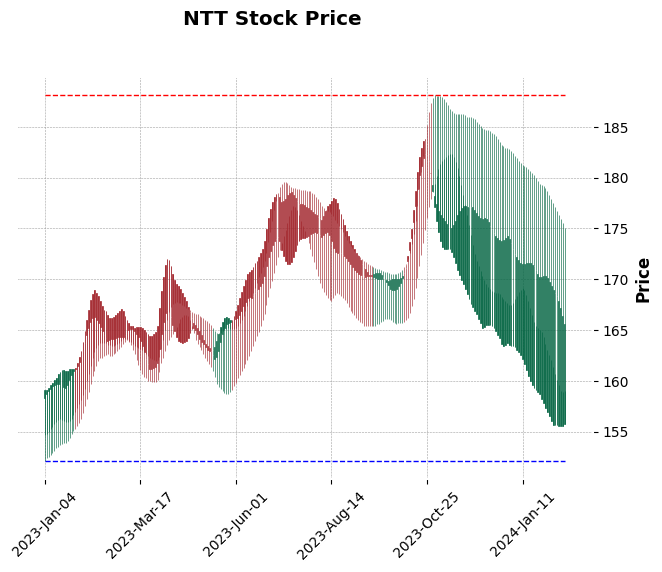

In [212]:
date_filter = "2022-12-31"
restored_ans = restored_ans[restored_ans.index > date_filter]

max_price = restored_ans['High'].max()
min_price = restored_ans['Low'].min()

# 最大値線と最小値線
max_line = mpf.make_addplot([max_price] * len(restored_ans), color='r', linestyle='--', width=1)
min_line = mpf.make_addplot([min_price] * len(restored_ans), color='b', linestyle='--', width=1)

# ローソク足チャート+移動平均
mpf.plot(
    data = restored_ans,
    type = "candle",
    addplot=[max_line, min_line],
    style = "charles",
    title = "NTT Stock Price",
    ylabel = "Price"
)


In [216]:
template_data = X_new[:, 0, :]

ans = pd.DataFrame(template_data, columns = df_merged.columns.to_list())
restored_data = scaler.inverse_transform(ans)

restored_ans = pd.DataFrame(restored_data, columns = df_merged.columns.to_list())
restored_ans.index = df_merged.index[:len(restored_ans)]

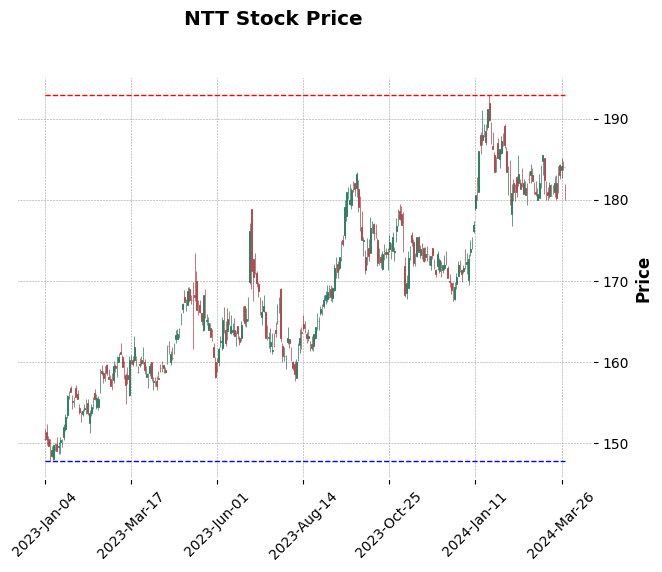

In [217]:
date_filter = "2022-12-31"
restored_ans = restored_ans[restored_ans.index > date_filter]

max_price = restored_ans['High'].max()
min_price = restored_ans['Low'].min()

# 最大値線と最小値線
max_line = mpf.make_addplot([max_price] * len(restored_ans), color='r', linestyle='--', width=1)
min_line = mpf.make_addplot([min_price] * len(restored_ans), color='b', linestyle='--', width=1)

# ローソク足チャート+移動平均
mpf.plot(
    data = restored_ans,
    type = "candle",
    addplot=[max_line, min_line],
    style = "charles",
    title = "NTT Stock Price",
    ylabel = "Price"
)

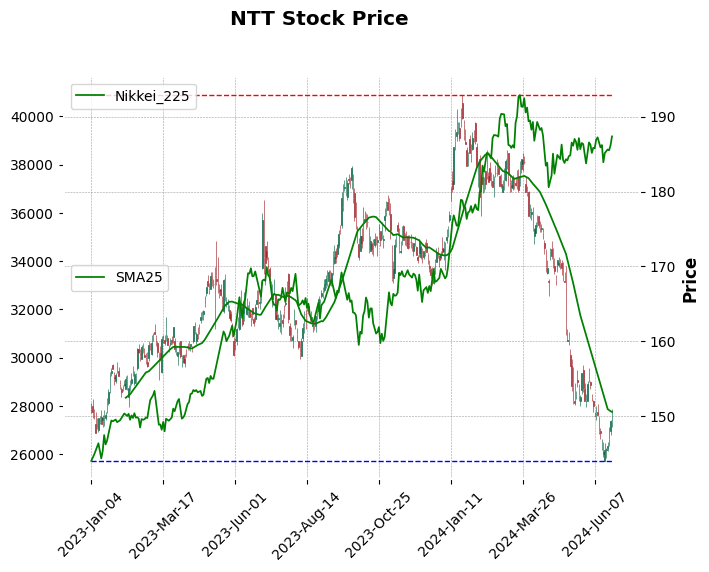

In [218]:
date_filter = "2022-12-31"
date_filtered_df = df_merged[df_merged.index > date_filter]

df_merged_filtered = rolling(date_filtered_df)

apds = [
    mpf.make_addplot(df_merged_filtered["SMA25"], color="green", label="SMA25"),
    mpf.make_addplot(df_merged_filtered["Value_ave"], color="green", label="Nikkei_225")
]

max_price = df_merged_filtered['High'].max()
min_price = df_merged_filtered['Low'].min()

# 最大値線と最小値線
max_line = mpf.make_addplot([max_price] * len(df_merged_filtered), color='r', linestyle='--', width=1)
min_line = mpf.make_addplot([min_price] * len(df_merged_filtered), color='b', linestyle='--', width=1)

# ローソク足チャート+移動平均
mpf.plot(
    data = df_merged_filtered,
    type = "candle",
    addplot=[*apds, max_line, min_line],
    style = "charles",
    title = "NTT Stock Price",
    ylabel = "Price",
)